In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp
import csv, warnings, math
import anchors
from poola import core as pool
from scipy.stats import ttest_ind
from scipy.interpolate import CubicSpline
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from adjustText import adjust_text

warnings.filterwarnings('ignore')
gpp.set_aesthetics(palette='Set2')


In [2]:
#Process data

def reformat_pDNA(df): 
    '''
    Inputs: df: pDNA dataframe from Poirier data set 
    Output: new_df: reformatted pDNA dataframe 
    '''
    #sgRNA: CHDH_GTGCCCACGGACGTAGACCA --> GTGCCCACGGACGTAGACCA
    new_df = df.copy()
    new_df = new_df.rename(columns = {'Guide': 'old_Guide', 'Reads':'pDNA'})
    new_guide_list = []
    gene_count = 1
    control_df = pd.DataFrame(columns = df.columns)
    df_dict = {}
    prev_gene = ''
    for i, row in enumerate(new_df.loc[:,'old_Guide']):
        gene = new_df.loc[i, 'Gene Symbol']
#         if 'Non-Targeting' in gene:
#             new_df.loc[i, 'Gene Symbol'] = 'Non-Targeting_'+str(i)
            #print(control_df)
        new_guide = row.split('_')[1]
        new_guide_list.append(new_guide) 
        #prev_gene = gene
    
    new_df['Guide'] = new_guide_list
    new_df = new_df.drop('old_Guide', axis = 1)
    new_df = new_df[['Guide', 'Gene Symbol', 'pDNA']]

    return new_df


def get_lognorm(df, cols = ['Reads'], new_col = ''):
    '''
    Inputs: 
    1. df: clean reads dataframe
    2. cols: list of names of column containing data used to calculate lognorm (default = ['Reads'])
    3. new_col: lognorm column name (optional) 
    Output: New dataframe with columns 'Gene Symbol', '[col]_Lognorm' (default = 'Reads_lognorm')
    '''
    df_lognorm = df.copy().drop(cols, axis = 1)
    for c in cols:
        #if not new_col: #if no lognorm column name specified 
        #df_lognorm[col+'_lognorm'] = np.log2(df[col]/df[col].sum()*1e6 +1)
        df_lognorm[c+'_lognorm'] = pool.lognorm(df[c])
        #else: 
            #df_lognorm[new_col] = np.log2(df[col]/df[col].sum()*1e6 +1)
            #df_lognorm[new_col] = pool.lognorm(df[c])
    return df_lognorm 


In [3]:
#QC 

def calculate_lfc(lognorm_df, target_cols, ref_col = 'pDNA_lognorm'): 
    '''
    Inputs:
    1. lognorm_df: Dataframe containing reference and target lognorm columns 
    2. target_cols: List containing target column name(s) (lognorm column(s) for which log-fold change should be calculated)
    3. ref_col: Reference column name (lognorm column relative to which log-fold change should be calculated)(default ref_col = 'pDNA_lognorm')
    '''
    #input df with lognorms + pDNA_lognorm
    lfc_df = pool.calculate_lfcs(lognorm_df=lognorm_df,ref_col='pDNA_lognorm', target_cols=target_cols)
    for col in target_cols: #rename log-fold change column so doesn't say "lognorm"
        lfc_col_name = col.replace('lognorm', 'lfc') 
        lfc_df = lfc_df.rename(columns = {col:lfc_col_name})
    return lfc_df

def get_controls(df, control_name = ['Non-Targeting'], separate = True):
    '''
    Inputs:
    1. df: Dataframe with columns "Gene Symbol" and data 
    2. control_name: list containing substrings that identify controls (default: 'NO_SITE', 'ONE_INTERGENIC')
    3. separate: determines whether to return non-targeting and intergenic controls separately (default = True)
    '''
    if len(control_name) == 1:
        control = df[df['Gene Symbol'].str.contains(control_name[0])]
        return control
    else:
        control_dict = {}
        for i, ctrl in enumerate(control_name):
            control_dict[ctrl] = df[df['Gene Symbol'].str.contains(ctrl)]
        if separate: 
            return control_dict

def get_gene_sets():
    '''
    Outputs: essential and non-essential genes as defined by Hart et al. 
    '''
    ess_genes = pd.read_csv('../Data/External/Gene_sets_Hart/essential-genes.txt', sep='\t', header=None)
    ess_genes.columns = ['Gene Symbol']
    ess_genes['ess-val'] = [1]*len(ess_genes)
    non_ess = pd.read_csv('../Data/External/Gene_sets_Hart/non-essential-genes.txt', sep='\t', header=None)
    non_ess.columns = ['Gene Symbol']
    non_ess['non-ess-val'] = [1]*len(non_ess)
    return ess_genes, non_ess

def merge_gene_sets(df):
    '''
    Input:
    1. df: data frame from which ROC-AUC is being calculated 
    Output:
    1. df: data frame with binary indicators for essential and non-essential genes 
    '''
    ess_genes, non_ess = get_gene_sets()
    df = pd.merge(df, ess_genes, on='Gene Symbol', how='left')
    df['ess-val'] = df['ess-val'].fillna(0)
    df = pd.merge(df, non_ess, on='Gene Symbol', how='left')
    df['non-ess-val'] = df['non-ess-val'].fillna(0)
    return df

def get_roc_auc(df, col):
    '''
    Inputs:
    1. df: data frame from which ROC-AUC is being calculated 
    2. col: column with data for which ROC-AUC is being calculated
    Outputs: 
    1. roc_auc: AUC value where true positives are essential genes and false positives are non-essential
    2. roc_df: dataframe used to plot ROC-AUC curve 
    '''
    df = df.sort_values(by=col)
    df['ess_cumsum'] = np.cumsum(df['ess-val'])
    df['non_ess_cumsum'] = np.cumsum(df['non-ess-val'])
    df['fpr'] = df['non_ess_cumsum']/(df['non_ess_cumsum'].iloc[-1])
    df['tpr'] = df['ess_cumsum']/(df['ess_cumsum'].iloc[-1])
    df.head()
    roc_auc = auc(df['fpr'],df['tpr'])
    roc_df = pd.DataFrame({'False_Positive_Rate':list(df.fpr), 'True_Positive_Rate':list(df.tpr)})
    return roc_auc, roc_df

def convertdftofloat(df):
    '''
    Converts df data column type into float 
    Input:
    1. df: data frame
    '''
    for col in df.columns[1:]:
        df[col] = df[col].astype(float) #convert dtype to float 
    return df

def new_rank_df(df, col = None, drop_col = True, ascending = False): #df with 2 cols "Gene Symbol" and scoring metric  
    '''
    Inputs:
    1. df: initial dataframe containing data that will be ranked
    2. col: column with data that will be ranked
    3. drop_col: bool indicating whether original data columns will be dropped in output df (default: True)
    4. ascending: direction of ranking (default: False)
    Output:
    rank_df: dataframe with ranked assigned to Gene Symbol 
    '''
    if not col:
        col = df.columns[1] #score column
    rank_df = pd.DataFrame()
    #print(col)
    rank_df = df.copy()[['Gene Symbol', col]]
    rank_df = df.sort_values(by = col, ascending = ascending).reset_index(drop = True) #column in descending order by default
    rank_col_name = 'Rank_' + col
    rank_df[rank_col_name] = rank_df.index + 1
    if drop_col: 
        rank_df = rank_df.copy().drop(col, axis = 1)
    rank_df = convertdftofloat(rank_df)
    return rank_df



In [4]:
## Plotting functions
def pair_cols(df, initial_id = 'initial', col_type = 'lfc'): #if more than one set of initial/resistant pop pairs, sharex = True, store pairs in list
    '''
    Inputs: 
    1. df: Dataframe containing log-fold change values and gene symbols 
    2. initial_id: string identifying initial column names (default: 'initial'), only used if multiple subplots
    3. col_type: string in names of columns containing data to be plotted (default: 'lfc')
    '''
    cols = [col for col in df.columns if col_type in col]
    pairs = [] #list of lists: ini/res pop pairs
    if len(cols) > 2: #if more than one set of initial/resistant pop pairs 
        sharex = True # set sharex parameter for subplot 
        for index, col in enumerate(cols):
            pair = []
            if initial_id in col: #find corresponding resistant pop
                pair.append(col)
                split_col = col.split(' ')
                ini_index = split_col.index('initial')
                res_col_string = ' '.join(split_col[:ini_index])
                if 'screen' in col: 
                    screen_index = split_col.index('screen')
                    screen = split_col[screen_index]
                    number = split_col[screen_index+1]
                    screen_str = screen + ' ' + number 
                    #res_col_string = res_col_string + ' ' + screen_str
                    print(res_col_string)
                    res_pop = [col for col in cols if (res_col_string in col) and ('resistant' in col) and (screen_str in col)]
                else:
                    res_pop = [col for col in cols if (res_col_string in col) and ('resistant' in col) and ('screen' not in col)]
                    
                    #res_col_string = col.replace('initial', 'resistant')
                    #print(screres_col_string)
                #for col in cols: 
                #res_pop = [col for col in cols if (res_col_string in col) and ('resistant' in col)]
                print(res_pop)
                for col in res_pop:
                    pair.append(col)
                    
                pairs.append(pair) #add to list of pairs (list of lists)
        return sharex, pairs
    else: #if only one pair of initial/resistant pops
        sharex = False
        pairs.append(cols)
        return sharex, pairs
    
def lfc_dist_plot(chip_lfc, ref_map = None, filename = '', figsize = (6,4)): #kde plots of population distribution (initial, resistant)
    '''
    Inputs: 
        1. chip_lfc: Dataframe containing log-fold change values and gene symbols 
        2. ref_map: Dataframe with two columns: 
                    -'initial': (string) name of column containing log-fold changes of uninfected population
                    -'resistant': list name(s) of column(s) containing log-fold changes of infected population
                        --> if there's more than one resistant population corresponding to the same initial population,
                            store as list in same cell 
                            
    Outputs: kde plots of population distribution (initial, resistant)
    '''
    if not ref_map:
        sharex, lfc_pairs = pair_cols(chip_lfc)

    fig, ax = plt.subplots(nrows = len(lfc_pairs), ncols = 1, sharex = sharex, figsize = figsize)
    
    #screen = get_df_name(chip_lfc).split('_')[-2:]
    i = 0 # ax index if have to plot multiple axes
    for k,c in enumerate(lfc_pairs):
        
        for l, c1 in enumerate(c):
            #title ex. Calu-3 Calabrese A screen 1, (k+1 = screen #)
            if not filename:
                title = ' '.join(c1.split(' ')[:3]) + ' (populations)'
            else:
                title = filename
            if l==0:
                label1 = 'Initial population'
            else:
                label1 = 'Resistant population-'+str(l)
                
            if sharex: #if multiple axes, ax = ax[i]
                chip_lfc[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label=label1, ax=ax[i], legend=True)
                t = ax[i].set_xlabel('Log-fold changes') 
                t = ax[i].set_title(title)
            else: 
                chip_lfc[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label=label1, ax=ax, legend=True)
                t = ax.set_xlabel('Log-fold changes')
                t = ax.set_title(title)
        i+=1
        sns.despine()   
    filepath = '../Figures/' + filename + '_popdist.png'
    print(filepath)
    fig.savefig(filepath, bbox_inches = 'tight')
    
#Control distributions
def control_dist_plot(chip_lfc, no_site = 'NonTargeting', filename = '', figsize = (6,4)): #kde plots of control distributions (initial, resistant)
    sharex, lfc_pairs = pair_cols(chip_lfc)
    #nosite, intergenic = get_controls(chip_lfc)
    nosite = get_controls(chip_lfc, [no_site])
    #all_controls = get_controls(chip_lfc, separate = False)
    nrows = len(lfc_pairs)
    
    fig, ax = plt.subplots(nrows = nrows, ncols = 1, sharex = sharex, figsize = figsize)
    i = 0 # ax index if have to plot multiple axes
    for k,c in enumerate(lfc_pairs): # k=screen, c=ini, res pair 
        for l, c1 in enumerate(c): # l = ini or res, c1 = pop label 
            title = c1 + ' (controls)'
            pop_label = c1.split(' ')[0] #labels 'initial' or 'resistant'
            #Plot same screen on same subplot 
            if sharex: #if multiple axes, ax = ax[i]
                nosite[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label='Non-targeting ('+pop_label+')', ax=ax[i], legend=True)
                ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                sns.despine()
                t = ax[i].set_xlabel('Log-fold changes')
                t = ax[i].set_title(title)
            else: 
                nosite[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label='Non-targeting ('+pop_label+')', ax=ax, legend=True)
                ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                sns.despine()
                t = ax.set_xlabel('Log-fold changes')
                t = ax.set_title(title)
        i+=1 #switch to next subplot for next screen

        sns.despine()
    filepath = '../Figures/' + filename + '_controldist.png'
    print(filepath)
    fig.savefig(filepath, bbox_inches = 'tight')
    

In [5]:
def run_guide_residuals(lfc_df):
    '''
    Calls get_guide_residuals function from anchors package to calculate guide-level residual z-scores
    Input:
    1. lfc_df: data frame with log-fold changes (relative to pDNA)
    
    '''
    lfc_df = lfc_df.drop_duplicates()
    paired_lfc_cols = pair_cols(lfc_df)[1] #get lfc pairs 
    modified = []
    unperturbed = []
    #reference_df: column1 = modifier condition, column2 = unperturbed column
    ref_df = pd.DataFrame(columns=['modified', 'unperturbed'])
    row = 0 #row index for reference df 
    for pair in paired_lfc_cols:
        #number of resistant pops in pair = len(pair)-1
        res_idx = 1 
        #if multiple resistant populations, iterate 
        while res_idx < len(pair): 
            ref_df.loc[row, 'modified'] = pair[res_idx]
            ref_df.loc[row, 'unperturbed'] = pair[0]
            res_idx +=1 
            row +=1
    print(ref_df)
    #input lfc_df, reference_df 
    #guide-level
    residuals_lfcs, all_model_info, model_fit_plots = anchors.get_guide_residuals(lfc_df, ref_df)
    return residuals_lfcs, all_model_info, model_fit_plots

def format_gene_residuals(df, guide_min = 5, guide_max = 7, conditions = []):
    '''
    Inputs: 
    1. df: gene_residuals output df 
    2. guide_min: min number of guides per gene to filter df
    3. guide_max: max number of guides per gene to filter df
    4. ascending: direction to sort df 
    Outputs:
    1. df_z: dataframe with the following columns: 
            -Gene Symbol
            -residual_zscore: residual_zscores averaged across conditions 
            -Rank_residual_zscore: 
    '''
    df = df[(df['guides']>=guide_min) & (df['guides']<=guide_max)]
    conditions = list(set(df.loc[:, 'condition']))
    print(conditions)
    #df_z = df[['condition', 'Gene Symbol', 'residual_zscore']]
    if len(conditions) > 1:
        df_z = df[['condition', 'Gene Symbol', 'residual_zscore']]
        condition_dict = {}
        for i, c in enumerate(conditions):
            print(c)
            condition_dict[c] = df_z[df_z['condition'] == c]
        #print(condition_dict) 
        merged_df_z = merge_dict_dfs(condition_dict, suffixes=['_x', '_y'])
        merged_df_z['residual_zscore_avg'] = merged_df_z.mean(axis = 1)
        #condition_cols = [col for col in merged_df_z.columns if 'condition' in col]
        df_z = merged_df_z.copy()[['Gene Symbol', 'residual_zscore_avg']]
        df_z = new_rank_df(df_z, 'residual_zscore_avg', drop_col=False)
    else:
        df_z = df[['Gene Symbol', 'residual_zscore']]
        df_z = new_rank_df(df_z, 'residual_zscore', drop_col=False)
        
    return df_z



## Data Summary

* Zhu et al.
* Cell line: A549 (overexpressing ACE2)
* Library: Brunello

In [6]:
#Read counts
reads_raw = pd.read_excel('../Data/Reads/Zhang/A549-ACE2 KO SARS2 screening count.xlsx')
reads_raw = reads_raw.rename(columns = {'sgRNA': 'Guide', 'Gene':'Gene Symbol'})
#pDNA reads from Schneider et al. 
pDNA_reads_raw = pd.read_excel('../Data/Reads/Poirier/Poirier_Brunello_pDNA.xlsx') # controls already grouped 
pDNA_reads = reformat_pDNA(pDNA_reads_raw)
reads = pd.merge(pDNA_reads, reads_raw, on = 'Guide', how = 'right')
reads = reads.drop('Gene Symbol_y', axis = 1)
reads = reads.rename(columns={'Gene Symbol_x':'Gene Symbol'})
reads

,Guide,Gene Symbol,pDNA,Control,Treatment
0,CATCTTCTTTCACCTGAACG,A1BG,118,1344,129
1,CTCCGGGGAGAACTCCGGCG,A1BG,68,819,200
2,TCTCCATGGTGCATCAGCAC,A1BG,2,3,20
3,TGGAAGTCCACTCCACTCAG,A1BG,116,1062,228
4,ACTGCATCTGTGCAAACGGG,A2M,70,766,146
...,...,...,...,...,...
77436,TTTGGTCAACGCATAGCTTG,Non-Targeting_94,182,2064,93
77437,TTTTACCTTGTTCACATGGA,Non-Targeting_82,177,2119,128
77438,TTTTGACTCTAATCACCGGT,Non-Targeting_225,107,1381,170
77439,TTTTTAATACAAGGTAATCT,Non-Targeting_25,55,1135,61


In [7]:
#Calculate lognorm

cols = reads.columns[2:].to_list() #reads columns are 3rd onward in df
lognorms = get_lognorm(reads.dropna(), cols = cols)
lognorms

,Guide,Gene Symbol,pDNA_lognorm,Control_lognorm,Treatment_lognorm
0,CATCTTCTTTCACCTGAACG,A1BG,4.468511,4.724628,2.432842
1,CTCCGGGGAGAACTCCGGCG,A1BG,3.720468,4.044591,2.967358
2,TCTCCATGGTGCATCAGCAC,A1BG,0.441787,0.079682,0.750266
3,TGGAAGTCCACTCCACTCAG,A1BG,4.444972,4.399295,3.133558
4,ACTGCATCTGTGCAAACGGG,A2M,3.759158,3.954108,2.579988
...,...,...,...,...,...
77436,TTTGGTCAACGCATAGCTTG,Non-Targeting_94,5.070563,5.324376,2.060662
77437,TTTTACCTTGTTCACATGGA,Non-Targeting_82,5.031586,5.361382,2.423701
77438,TTTTGACTCTAATCACCGGT,Non-Targeting_225,4.334018,4.762345,2.765083
77439,TTTTTAATACAAGGTAATCT,Non-Targeting_25,3.440005,4.490800,1.623124


## Quality Control
### Population Distributions

../Figures/A549_Brunello_Zhang_popdist.png


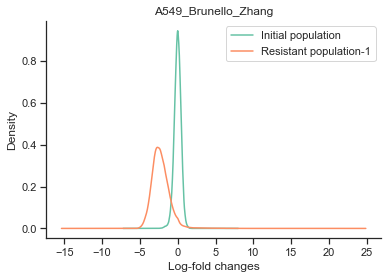

In [8]:
#Calculate log-fold change relative to pDNA
target_cols = list(lognorms.columns[3:])
pDNA_lfc = calculate_lfc(lognorms,target_cols)
#Plot population distributions of log-fold changes 
lfc_dist_plot(pDNA_lfc, filename = 'A549_Brunello_Zhang')

### Control Distributions

../Figures/A549_Brunello_Zhang_controldist.png


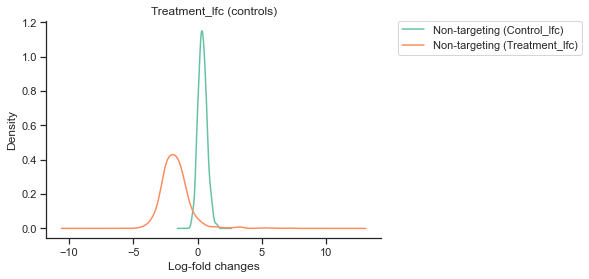

In [9]:
control_dist_plot(pDNA_lfc, no_site='Non-Targeting', filename = 'A549_Brunello_Zhang')

### ROC-AUC

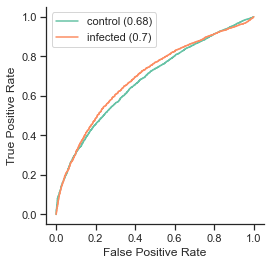

In [10]:
#Plot ROC-AUC
lfc_pair = pair_cols(pDNA_lfc)[1][0]
control_col = lfc_pair[0]
res_col = lfc_pair[1]
df_ann = merge_gene_sets(pDNA_lfc)
#print(df_ann)
roc_auc_ctrl, roc_df_ctrl = get_roc_auc(df_ann, control_col)
roc_auc_res, roc_df_res = get_roc_auc(df_ann, res_col)
fig, ax = plt.subplots()
g = plt.plot(roc_df_ctrl.False_Positive_Rate, roc_df_ctrl.True_Positive_Rate, label = 'control ('+str(np.round(roc_auc_ctrl,2))+')')
g = plt.plot(roc_df_res.False_Positive_Rate, roc_df_res.True_Positive_Rate, label = 'infected ('+str(np.round(roc_auc_res,2))+')')
t = plt.xlabel('False Positive Rate')
t = plt.ylabel('True Positive Rate')
sns.despine()
ax.set_aspect('equal')
t = plt.legend()
fig.savefig('../Figures/Zhang_ROC-AUC.png', dpi=1000)


## Gene-level analysis

### Residual z-scores

In [11]:
#Calculate z-scores of lfc residuals
lfc_df = pDNA_lfc.copy().drop(['Gene Symbol'], axis = 1)
lfc_df = lfc_df.dropna()

guide_residuals_lfcs, all_model_info, model_fit_plots = run_guide_residuals(lfc_df)

guide_mapping = pDNA_lfc[['Guide', 'Gene Symbol']]

gene_residuals = anchors.get_gene_residuals(guide_residuals_lfcs, guide_mapping)
gene_residuals

        modified  unperturbed
0  Treatment_lfc  Control_lfc


,condition,Gene Symbol,guides,avg_lfc,avg_lfc_reference,residual_zscore,p_value,fdr_bh
0,Treatment_lfc,A1BG,4,-0.947928,0.043115,2.246416,0.024677,0.580965
1,Treatment_lfc,A1CF,4,-2.633417,0.308452,-1.275733,0.202050,0.999409
2,Treatment_lfc,A2M,4,-2.391853,0.364319,-0.945705,0.344299,0.999409
3,Treatment_lfc,A2ML1,4,-1.917494,-0.007532,0.597194,0.550378,0.999409
4,Treatment_lfc,A3GALT2,4,-1.298894,0.038376,1.618824,0.105485,0.948595
...,...,...,...,...,...,...,...,...
19359,Treatment_lfc,ZYG11A,4,-1.934661,0.064359,0.433823,0.664417,0.999409
19360,Treatment_lfc,ZYG11B,4,-2.430009,-0.068091,-0.225112,0.821892,0.999409
19361,Treatment_lfc,ZYX,4,-1.370474,-0.007905,1.583137,0.113390,0.956970
19362,Treatment_lfc,ZZEF1,4,-1.404886,-0.288910,2.009764,0.044456,0.756059


In [12]:
gene_residual_sheet = format_gene_residuals(gene_residuals, guide_min = 3, guide_max = 5)
guide_residual_sheet = pd.merge(guide_mapping, guide_residuals_lfcs, on = 'Guide', how = 'outer')
guide_residual_sheet

['Treatment_lfc']


,Guide,Gene Symbol,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,CATCTTCTTTCACCTGAACG,A1BG,Treatment_lfc,-0.059254,-0.053298,Control_lfc,-2.035669,0.256117
1,CTCCGGGGAGAACTCCGGCG,A1BG,Treatment_lfc,1.152371,1.036536,Control_lfc,-0.753110,0.324123
2,TCTCCATGGTGCATCAGCAC,A1BG,Treatment_lfc,2.920745,2.627153,Control_lfc,0.308478,-0.362106
3,TGGAAGTCCACTCCACTCAG,A1BG,Treatment_lfc,0.981056,0.882440,Control_lfc,-1.311413,-0.045676
4,ACTGCATCTGTGCAAACGGG,A2M,Treatment_lfc,0.861268,0.774694,Control_lfc,-1.179169,0.194950
...,...,...,...,...,...,...,...,...
77436,TTTGGTCAACGCATAGCTTG,Non-Targeting_94,Treatment_lfc,-1.031079,-0.927436,Control_lfc,-3.009901,0.253814
77437,TTTTACCTTGTTCACATGGA,Non-Targeting_82,Treatment_lfc,-0.708310,-0.637111,Control_lfc,-2.607885,0.329796
77438,TTTTGACTCTAATCACCGGT,Non-Targeting_225,Treatment_lfc,0.228353,0.205399,Control_lfc,-1.568935,0.428327
77439,TTTTTAATACAAGGTAATCT,Non-Targeting_25,Treatment_lfc,-0.654214,-0.588453,Control_lfc,-1.816881,1.050795


In [13]:
with pd.ExcelWriter('../Data/Processed/GEO_submission/A549_Brunello_Zhang.xlsx') as writer:  
    gene_residual_sheet.to_excel(writer, sheet_name='A549_Brunello_avg_zscore', index =False)
    reads.to_excel(writer, sheet_name='A549_Brunello_genomewide_reads', index =False)
    guide_mapping.to_excel(writer, sheet_name='A549_Brunello_guide_mapping', index =False)

In [14]:
with pd.ExcelWriter('../Data/Processed/Individual_screens/A549_Brunello_Zhang_v2.xlsx') as writer:   
    gene_residuals.to_excel(writer, sheet_name='gene-level_zscore', index =False)
    guide_residual_sheet.to_excel(writer, sheet_name='guide-level_zscore', index =False)